In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import pmdarima as pm
from pmdarima import auto_arima,arima
import warnings
from sklearn.preprocessing import MinMaxScaler
# get functions from utils.py
from utils import *
from joblib import dump
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
ari = pd.read_csv("data_ari.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])


In [4]:
ili = pd.read_csv("data_ili.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])
ili = ili.drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [5]:
def train_test_rnn(full_df, location, date, n_input=16, n_output=4):
    # Filter country and set data
    data_location = full_df[full_df['location'] == location].copy()
    data_location['truth_date'] = pd.to_datetime(data_location['truth_date'])
    data_location = data_location.set_index('truth_date')

    # features
    data = create_features(data_location)
    data.drop(columns=['location'], inplace=True)

    train = data[data.index <= date].copy()
    test = data[data.index > date].copy()

    # Scaling 
    var = ['relative_humidity_2m', 'temperature_2m_max', 'temperature_2m_min',
           'lag_value_1', 'lag_humidity_1', 'lag_temp_max_1', 'lag_temp_min_1',
           'lag_value_2', 'lag_humidity_2', 'lag_temp_max_2', 'lag_temp_min_2',
           'lag_value_3', 'lag_humidity_3', 'lag_temp_max_3', 'lag_temp_min_3',
           'lag_value_4', 'lag_humidity_4', 'lag_temp_max_4', 'lag_temp_min_4']
    
    var2 = ['value', 'week_mas_1', 'week_mas_2', 'week_mas_3']
    print(train.corr()['value'].sort_values(ascending=False))
    scal = MinMaxScaler()
    scal_2 = MinMaxScaler()

    train[var] = scal.fit_transform(train[var])
    test[var] = scal.transform(test[var])

    train[var2] = scal_2.fit_transform(train[var2])
    test[var2] = scal_2.transform(test[var2])

    # union data to generate sequences
    full_scaled = pd.concat([train, test])
    full_scaled.drop(columns=['week_mas_1', 'week_mas_2', 'week_mas_3'])
    print(full_scaled.columns)
    X_all, y_all = generate_sequences(full_scaled, target_col='value', n_input=n_input, n_output=n_output)

    # dates
    dates = full_scaled.index[n_input + n_output - 1:]

    idx = dates.get_indexer([pd.to_datetime(date)])
    
    split_idx = idx[0]

    # Train test split to train model
    X_train, y_train = X_all[:split_idx], y_all[:split_idx]
    X_test, y_test = X_all[split_idx:], y_all[split_idx:]

    return X_train, y_train, X_test, y_test, scal_2, scal, dates


In [6]:
def create_features_rnn(data):
    """
    Create additional features for the non sequential dataset.
    """
    data = data.copy()

    # Extract year, month, day, weekday, and week from 'truth_date'
    data['year'] = data.index.year
    data['month'] = data.index.month

    week = data['year_week'].str.split('-W').str[1]
    data['week'] = week.astype(int)
    for h in range(1,53):
        data[f'lag_value_{h}'] = data['value'].shift(h)
        data[f'lag_humidity_{h}'] = data['relative_humidity_2m'].shift(h)
        data[f'lag_temp_max_{h}'] = data['temperature_2m_max'].shift(h)
        data[f'lag_temp_min_{h}'] = data['temperature_2m_min'].shift(h)
    data = data.dropna()
    # Convert cyclical categorical variables to category type
    data['month_sin'] = np.sin(2 * np.pi * data['month']/12)
    data['month_cos'] = np.cos(2 * np.pi * data['month']/12)
    data['week_sin'] = np.sin(2 * np.pi * data['week']/52)
    data['week_cos'] = np.cos(2 * np.pi * data['week']/52)
    data = data.drop(columns=['month', 'week','year_week'])
    data['week_mas_1'] = data['value'].shift(-1)
    data['week_mas_2'] = data['value'].shift(-2)
    data['week_mas_3'] = data['value'].shift(-3)
    return data

In [7]:
mape_ari = pd.DataFrame(columns=['location','model','prediction_window','mae','rmse'])
mape_ili = pd.DataFrame(columns=['location','model','prediction_window','mae','rmse'])

In [8]:
def build_lstm_model(X_train,y_train, n_features = 76, n_input=52, epochs=100, batch_size=32,
                     n_output=4, model_name=None, country=None, mape=None, scal_2=None):


    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=(n_input, n_features)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(n_output)
    ])

    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train,
              validation_split=0.1,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stop],
              verbose=1)
    dump(model, f"models_rnn/rnn_model_{country}_{model_name}.joblib")
    return model


In [9]:
def prediction_rnn(model,X_test,y_test,n_features=76, n_input=16, n_output=4, model_name=None, country=None, mape=None, scal_2=None,dates=None):

    y_test_df = pd.DataFrame(y_test, columns=['value', 'week_mas_1', 'week_mas_2', 'week_mas_3'])
    true_real = pd.DataFrame(scal_2.inverse_transform(y_test_df), columns=['value', 'week_mas_1', 'week_mas_2', 'week_mas_3'])
    # Rolling predictions
    rolling_raw = []
    for i in range(len(X_test)):
        input_seq = X_test[i].reshape(1, n_input, n_features)
        pred_scaled = model.predict(input_seq, verbose=0)
        rolling_raw.append(pred_scaled.flatten())

    rolling_df = pd.DataFrame(rolling_raw, columns=[f"prediction_{i+1}_weeks" for i in range(n_output)])
    rolling_df_inverse = pd.DataFrame(scal_2.inverse_transform(rolling_df), columns=[f"prediction_{i+1}_weeks" for i in range(n_output)])

    results = []
    for i in range(n_output):
        mae, rmse = eval_metrics(true_real.iloc[:, i], rolling_df_inverse.iloc[:, i])
        results.append([country, model_name, f"{i+1}_week", mae, rmse])

    mape = pd.concat([
        mape,
        pd.DataFrame(results, columns=['location', 'model', 'prediction_window', 'mae', 'rmse'])
    ], ignore_index=True)
    rolling_df_inverse.index = dates[-rolling_df_inverse.shape[0]:]
    true_real.index = dates[-true_real.shape[0]:] 
    return rolling_df_inverse, mape, true_real

In [137]:
for i in name_ari:
    print(f"Training model for {i}")
    X_train, y_train, X_test, y_test, scal_2, scal, dates = train_test_rnn(ari,i,'2023-10-15', n_input=52, n_output=4)
    model= build_lstm_model(X_train,y_train ,n_features=76, n_input=52, epochs=200, batch_size=32,
                 n_output=4, model_name='ARI', country=i, mape=mape_ari, scal_2=scal)
    y_train_df = pd.DataFrame(y_train, columns=['value', 'week_mas_1', 'week_mas_2', 'week_mas_3'])
    y_train_df_inv = pd.DataFrame(scal_2.inverse_transform(y_train_df), columns=['value', 'week_mas_1', 'week_mas_2', 'week_mas_3'])
    y_train_df_inv.index = dates[:y_train_df_inv.shape[0]]
    test_aux, mape_ari, true_real= prediction_rnn(model,X_test,y_test,n_features=76, n_input=52, n_output=4, model_name='ARI', country=i, mape=mape_ari, scal_2=scal_2,dates=dates)
    test_aux['value'] = true_real['value']
    plot_train_test(y_train_df_inv, test_aux, 'ARI', i,'rnn')

    

Training model for CZ
value                   1.000000
lag_value_1             0.950374
week_mas_1              0.950352
lag_value_2             0.880558
week_mas_2              0.880334
lag_value_3             0.805418
week_mas_3              0.804141
lag_value_4             0.709456
week_cos                0.673005
month_cos               0.569057
lag_humidity_4          0.551592
lag_humidity_3          0.539606
lag_humidity_2          0.503978
lag_humidity_1          0.468097
month_sin               0.442711
relative_humidity_2m    0.442370
week_sin                0.279124
year                   -0.062595
covid                  -0.174808
lag_temp_min_4         -0.582639
lag_temp_max_4         -0.626973
lag_temp_min_3         -0.638832
lag_temp_max_3         -0.669931
lag_temp_min_2         -0.677516
temperature_2m_max     -0.689196
lag_temp_max_2         -0.690196
lag_temp_max_1         -0.698902
temperature_2m_min     -0.699458
lag_temp_min_1         -0.702140
Name: value, dtype: f

c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 28 and 76 for '{{node sequential_43_1/bidirectional_86_1/forward_lstm_86_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_43_1/bidirectional_86_1/forward_lstm_86_1/strided_slice_2, sequential_43_1/bidirectional_86_1/forward_lstm_86_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,28], [76,512].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 28), dtype=float32)
  • states=('tf.Tensor(shape=(None, 128), dtype=float32)', 'tf.Tensor(shape=(None, 128), dtype=float32)')
  • training=True

In [ ]:
mape_ari.to_csv('mape_ari_rnn.csv', index=False)

Training model for LV
value                   1.000000
lag_value_1             0.900210
week_mas_1              0.900182
lag_value_2             0.731818
week_mas_2              0.731679
lag_value_3             0.552929
week_mas_3              0.552595
lag_value_4             0.404751
month_sin               0.306214
week_sin                0.241389
lag_humidity_4          0.214197
week_cos                0.197933
lag_humidity_3          0.194948
lag_humidity_2          0.190444
lag_humidity_1          0.178537
year                    0.115201
relative_humidity_2m    0.114362
month_cos               0.088015
covid                  -0.015270
temperature_2m_max     -0.278134
temperature_2m_min     -0.282644
lag_temp_max_1         -0.336848
lag_temp_min_1         -0.342956
lag_temp_max_2         -0.401790
lag_temp_min_2         -0.413549
lag_temp_min_4         -0.414340
lag_temp_max_4         -0.434920
lag_temp_max_3         -0.437092
lag_temp_min_3         -0.441883
Name: value, dtype: f

c:\Users\flore\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0777 - val_loss: 0.1440
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0202 - val_loss: 0.1469
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0195 - val_loss: 0.1415
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0171 - val_loss: 0.1416
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0152 - val_loss: 0.1402
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0137 - val_loss: 0.1383
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0150 - val_loss: 0.1373
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0160 - val_loss: 0.1392
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0162 - val_loss: 0.1374
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0174 - val_loss: 0.1381
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0139 - val_loss: 0.1394
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0152 - val_l

C:\Users\flore\AppData\Local\Temp\ipykernel_5784\3603826462.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape = pd.concat([


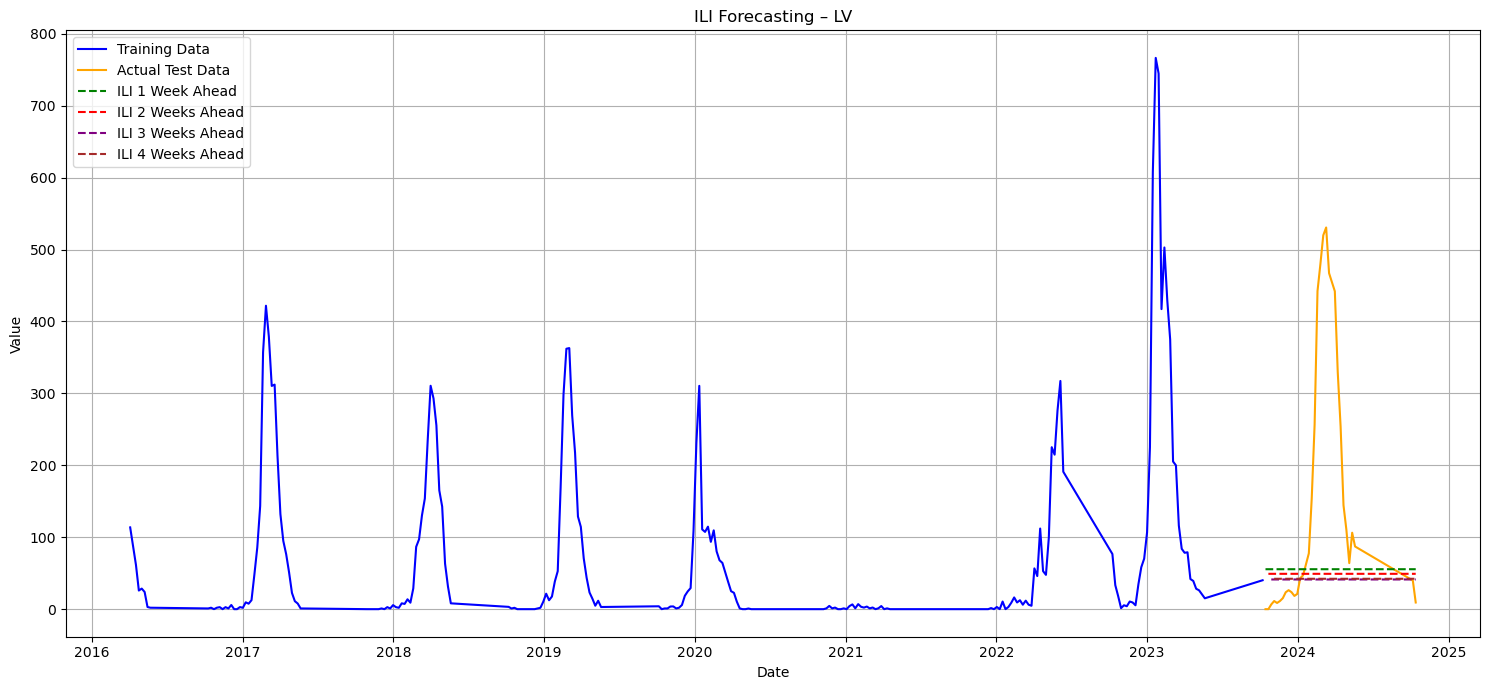

In [10]:
for i in ['LV']:
    print(f"Training model for {i}")
    X_train, y_train, X_test, y_test, scal_2, scal, dates = train_test_rnn(ili,i,'2023-10-15', n_input=52, n_output=4)
    model= build_lstm_model(X_train,y_train ,n_features=28, n_input=52, epochs=200, batch_size=32,
                 n_output=4, model_name='ILI', country=i, mape=mape_ili, scal_2=scal)
    y_train_df = pd.DataFrame(y_train, columns=['value', 'week_mas_1', 'week_mas_2', 'week_mas_3'])
    y_train_df_inv = pd.DataFrame(scal_2.inverse_transform(y_train_df), columns=['value', 'week_mas_1', 'week_mas_2', 'week_mas_3'])
    y_train_df_inv.index = dates[:y_train_df_inv.shape[0]]
    test_aux, mape_ili, true_real= prediction_rnn(model,X_test,y_test,n_features=28, n_input=52, n_output=4, model_name='ILI', country=i, mape=mape_ili, scal_2=scal_2,dates=dates)
    test_aux['value'] = true_real['value']
    plot_train_test(y_train_df_inv, test_aux, 'ILI', i,'rnn')

In [11]:
mape_ili

,location,model,prediction_window,mae,rmse
0,LV,ILI,1_week,126.276634,198.011612
1,LV,ILI,2_week,126.190369,200.967896
2,LV,ILI,3_week,126.413025,204.825089
3,LV,ILI,4_week,126.379219,204.348816


In [ ]:
mape_ili.to_csv('mape_ili_rnn.csv', index=False)